## Setup

Either run this notebook in the conda environment specified by environment.yml,
or run the commands below to install necessary dependencies.

In [ ]:
!sudo apt-get install --quiet -y poppler-utils
!pip install git+https://github.com/krishanr/zoterorag
!pip install git+https://github.com/illuin-tech/colpali

Uncomment then run the line below after replacing ZOTERO_API_KEY and HUGGINGFACE_ACCESS_TOKEN with their respective keys. <br/>
To try the demo on a first pass, the ZOTERO_API_KEY can be omitted.

In [ ]:
#!touch .env && echo ZOTERO_API_KEY=ZOTERO_API_KEY >> .env && echo HUGGINGFACE_ACCESS_TOKEN=HUGGINGFACE_ACCESS_TOKEN >> .env

In [1]:
import os
import torch
import time
import numpy as np
from tqdm import tqdm
from IPython.display import display, Markdown

from zoterorag.rag import RAG  
from zoterorag.datamodel import Document
from pyzotero import zotero
from zoterorag.utils import show_thumbnails

from dotenv import load_dotenv

from zoterorag.utils import show_thumbnails

load_dotenv()


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.8.0+cu128 with CUDA 1208 (you have 2.7.1+cu126)
    Python  3.9.23 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


Unsloth: If you want to finetune Gemma 2, upgrade flash-attn to version 2.6.3 or higher!
Newer versions support faster and less memory usage kernels for Gemma 2's attention softcapping!
To update flash-attn, do the below:

pip install --no-deps --no-build-isolation --upgrade "flash-attn>=2.6.3"
🦥 Unsloth Zoo will now patch everything to make training faster!


True

In [4]:
# Choose the zotero library you want to use to build your RAG database.
library_id = "17717148"
library_type = "user"

if os.getenv("ZOTERO_API_KEY",None):
    zot = zotero.Zotero(library_id, library_type, os.getenv("ZOTERO_API_KEY"))
else:
    zot = None

In [ ]:
qdrant_local_url = ":memory:"
qdrant_collection = "zotero_library"
retrieval_model = "nomic-ai/nomic-embed-multimodal-3b"

rag = RAG(qdrant_local_url, qdrant_collection, retrieval_model, device="cuda")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


## Setup qdrant vector database and index data

If you don't have access to zotero, comment the line ```items=None``` at the end of the cell below,
so that the sample data below is used.

In [ ]:
items = [{'version': 283,
  'library': {'type': 'user'},
  'meta': {'creatorSummary': 'Faysse et al.',
   'parsedDate': '2025-02-28',
   'numChildren': 3},
  'data': {'version': 283,
   'itemType': 'preprint',
   'title': 'ColPali: Efficient Document Retrieval with Vision Language Models',
   'creators': [{'creatorType': 'author',
     'firstName': 'Manuel',
     'lastName': 'Faysse'},
    {'creatorType': 'author', 'firstName': 'Hugues', 'lastName': 'Sibille'},
    {'creatorType': 'author', 'firstName': 'Tony', 'lastName': 'Wu'},
    {'creatorType': 'author', 'firstName': 'Bilel', 'lastName': 'Omrani'},
    {'creatorType': 'author', 'firstName': 'Gautier', 'lastName': 'Viaud'},
    {'creatorType': 'author', 'firstName': 'Céline', 'lastName': 'Hudelot'},
    {'creatorType': 'author', 'firstName': 'Pierre', 'lastName': 'Colombo'}],
   'abstractNote': 'Documents are visually rich structures that convey information through text, but also figures, page layouts, tables, or even fonts. Since modern retrieval systems mainly rely on the textual information they extract from document pages to index documents -often through lengthy and brittle processes-, they struggle to exploit key visual cues efficiently. This limits their capabilities in many practical document retrieval applications such as Retrieval Augmented Generation (RAG). To benchmark current systems on visually rich document retrieval, we introduce the Visual Document Retrieval Benchmark ViDoRe, composed of various page-level retrieval tasks spanning multiple domains, languages, and practical settings. The inherent complexity and performance shortcomings of modern systems motivate a new concept; doing document retrieval by directly embedding the images of the document pages. We release ColPali, a Vision Language Model trained to produce high-quality multi-vector embeddings from images of document pages. Combined with a late interaction matching mechanism, ColPali largely outperforms modern document retrieval pipelines while being drastically simpler, faster and end-to-end trainable. We release models, data, code and benchmarks under open licenses at https://hf.co/vidore.',
   'genre': '',
   'repository': 'arXiv',
   'archiveID': 'arXiv:2407.01449',
   'place': '',
   'date': '2025-02-28',
   'series': '',
   'seriesNumber': '',
   'DOI': '10.48550/arXiv.2407.01449',
   'citationKey': '',
   'url': 'http://arxiv.org/abs/2407.01449',
   'accessDate': '2025-08-12T23:29:26Z',
   'archive': '',
   'archiveLocation': '',
   'shortTitle': 'ColPali',
   'language': '',
   'libraryCatalog': 'arXiv.org',
   'callNumber': '',
   'rights': '',
   'extra': 'arXiv:2407.01449 [cs]',
   'tags': [{'tag': 'Computer Science - Computation and Language', 'type': 1},
    {'tag': 'Computer Science - Computer Vision and Pattern Recognition',
     'type': 1},
    {'tag': 'Computer Science - Information Retrieval', 'type': 1}],
   'collections': [],
   'relations': {},
   'dateAdded': '2025-08-12T23:29:26Z',
   'dateModified': '2025-08-12T23:29:26Z'}},
 {'version': 279,
  'library': {'type': 'user'},
  'meta': {'creatorSummary': 'Team',
   'parsedDate': '2025-04-29',
   'numChildren': 1},
  'data': {'version': 279,
   'itemType': 'webpage',
   'title': 'Qwen3: Think Deeper, Act Faster',
   'creators': [{'creatorType': 'author',
     'firstName': 'Qwen',
     'lastName': 'Team'}],
   'abstractNote': 'QWEN CHAT GitHub Hugging Face ModelScope Kaggle DEMO DISCORD\nIntroduction Today, we are excited to announce the release of Qwen3, the latest addition to the Qwen family of large language models. Our flagship model, Qwen3-235B-A22B, achieves competitive results in benchmark evaluations of coding, math, general capabilities, etc., when compared to other top-tier models such as DeepSeek-R1, o1, o3-mini, Grok-3, and Gemini-2.5-Pro. Additionally, the small MoE model, Qwen3-30B-A3B, outcompetes QwQ-32B with 10 times of activated parameters, and even a tiny model like Qwen3-4B can rival the performance of Qwen2.',
   'websiteTitle': 'Qwen',
   'websiteType': '',
   'date': '2025-04-29T04:00:00+08:00',
   'shortTitle': 'Qwen3',
   'url': 'https://qwenlm.github.io/blog/qwen3/',
   'accessDate': '2025-08-12T19:58:07Z',
   'language': 'en',
   'rights': '',
   'extra': 'Section: blog',
   'tags': [],
   'collections': [],
   'relations': {},
   'dateAdded': '2025-08-12T19:58:07Z',
   'dateModified': '2025-08-12T19:58:07Z'}},
 {'version': 275,
  'library': {'type': 'user'},
  'meta': {'creatorSummary': 'Thakur et al.',
   'parsedDate': '2021-10-21',
   'numChildren': 3},
  'data': {'version': 275,
   'itemType': 'preprint',
   'title': 'BEIR: A Heterogenous Benchmark for Zero-shot Evaluation of Information Retrieval Models',
   'creators': [{'creatorType': 'author',
     'firstName': 'Nandan',
     'lastName': 'Thakur'},
    {'creatorType': 'author', 'firstName': 'Nils', 'lastName': 'Reimers'},
    {'creatorType': 'author', 'firstName': 'Andreas', 'lastName': 'Rücklé'},
    {'creatorType': 'author',
     'firstName': 'Abhishek',
     'lastName': 'Srivastava'},
    {'creatorType': 'author', 'firstName': 'Iryna', 'lastName': 'Gurevych'}],
   'abstractNote': 'Existing neural information retrieval (IR) models have often been studied in homogeneous and narrow settings, which has considerably limited insights into their out-of-distribution (OOD) generalization capabilities. To address this, and to facilitate researchers to broadly evaluate the effectiveness of their models, we introduce Benchmarking-IR (BEIR), a robust and heterogeneous evaluation benchmark for information retrieval. We leverage a careful selection of 18 publicly available datasets from diverse text retrieval tasks and domains and evaluate 10 state-of-the-art retrieval systems including lexical, sparse, dense, late-interaction and re-ranking architectures on the BEIR benchmark. Our results show BM25 is a robust baseline and re-ranking and late-interaction-based models on average achieve the best zero-shot performances, however, at high computational costs. In contrast, dense and sparse-retrieval models are computationally more efficient but often underperform other approaches, highlighting the considerable room for improvement in their generalization capabilities. We hope this framework allows us to better evaluate and understand existing retrieval systems, and contributes to accelerating progress towards better robust and generalizable systems in the future. BEIR is publicly available at https://github.com/UKPLab/beir.',
   'genre': '',
   'repository': 'arXiv',
   'archiveID': 'arXiv:2104.08663',
   'place': '',
   'date': '2021-10-21',
   'series': '',
   'seriesNumber': '',
   'DOI': '10.48550/arXiv.2104.08663',
   'citationKey': '',
   'url': 'http://arxiv.org/abs/2104.08663',
   'accessDate': '2025-08-12T19:27:34Z',
   'archive': '',
   'archiveLocation': '',
   'shortTitle': 'BEIR',
   'language': '',
   'libraryCatalog': 'arXiv.org',
   'callNumber': '',
   'rights': '',
   'extra': 'arXiv:2104.08663 [cs]',
   'tags': [{'tag': 'Computer Science - Artificial Intelligence', 'type': 1},
    {'tag': 'Computer Science - Computation and Language', 'type': 1},
    {'tag': 'Computer Science - Information Retrieval', 'type': 1}],
   'collections': [],
   'relations': {},
   'dateAdded': '2025-08-12T19:27:34Z',
   'dateModified': '2025-08-12T19:27:34Z'}}]
#items = None

In [ ]:
# If not using the sample data, then load data from zotero.
if not items:
    items = zot.everything(zot.top())

Increase ```item_count``` below as desired. A larger number of documents
will require greater processing times.

In [ ]:
# Indexing process 
rag.create_collection()

# Only load first 3 items from zotero for the demo.
item_count = 3
start_time = time.time()
text = []
images = []
for item in items[:item_count]:
    # Pass in zot here if zotero data contains books or PDFs.
    dat = Document.load(item['data']['url'],item, zot=None)
    text.extend(dat.get_text())
    images.extend(dat.get_images())

print(f"Data download time was {time.time()-start_time}")


PDF downloaded successfully to temp_folder/2407.01449.pdf


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  7.50it/s]


PDF downloaded successfully to temp_folder/2104.08663.pdf


In [ ]:
start_time = time.time()
rag.index_dataset(text,type  = "text",batch_size = 2)
rag.index_dataset(images,type = "image",batch_size = 2)

# For some reason the text data has to be indexed twice..
rag.index_dataset(text,type  = "text",batch_size = 2)
print(f"Data indexing time was {time.time()-start_time}")

Indexing Progress: 2it [00:00,  3.39it/s]               


Indexing complete!


Indexing Progress: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


Indexing complete!


Indexing Progress: 2it [00:00,  3.45it/s]               

Indexing complete!


## Run query

Qdrant search completed in 0.0093 seconds


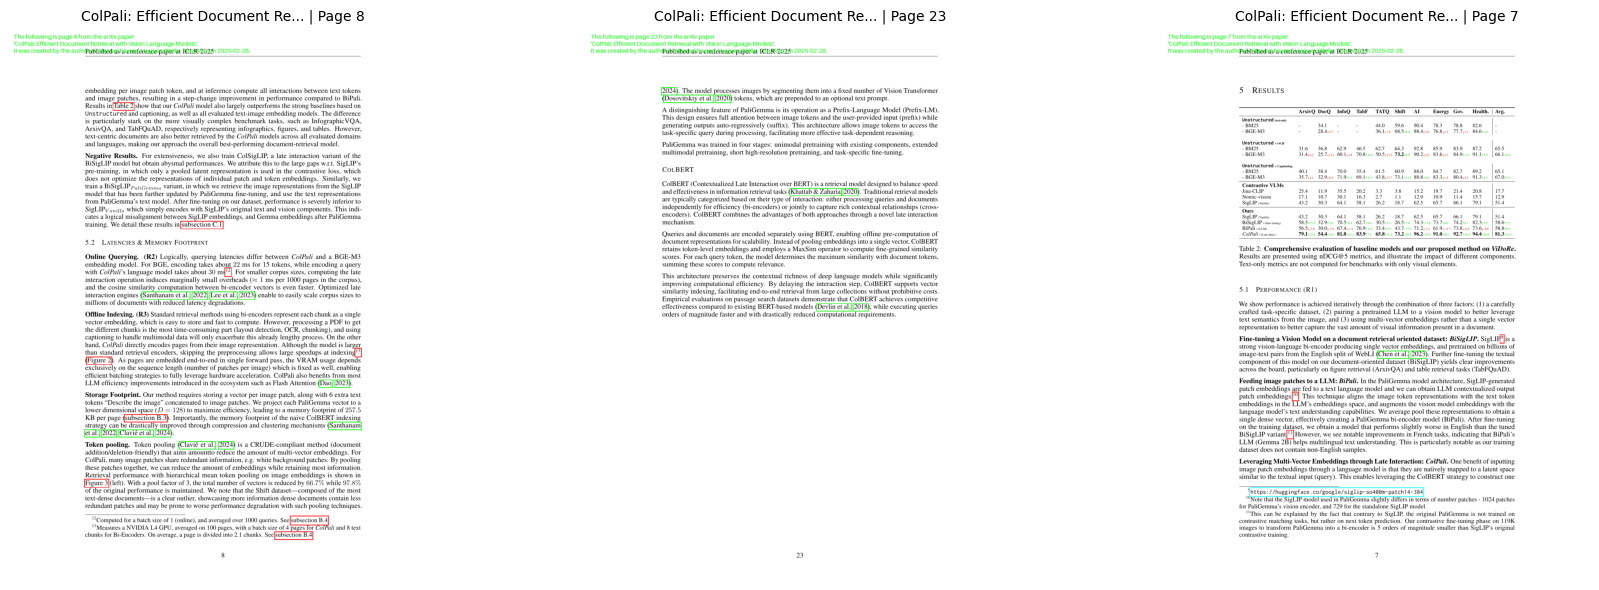

Text query has length 78.
The passage from page 8 of "CoLPali: Efficient Document Retrieval with Vision Language Models" discusses how ColPali performs better compared to BM25 (BM25 is a common vector-based text embedding model) in various document retrieval tasks. The following key points are highlighted:

1. **Embeddings and Retrieval Efficiency**: The document mentions that CoLPali processes images by segmenting them into fixed numbers of Vision Transformers, which are then concatenated along with textual features.

2. **Comparison with B-Match and Bi-Encoders**: The paper explains that for specific types of documents like infographics, figures, and tables, CoLPali outperforms existing methods including B-Match and cross-encoders such as Bi-Encoders.

3. **Latency Considerations**: When comparing with existing BGE-M3 embeddings, CoPali's latency performance is discussed. The passage notes that queries on CoPali's embedding take about 0.42 milliseconds versus 33 milli seconds (ms) fo

In [15]:
query_text = "How does ColPali compare with BM25?"
search_result = rag.search(query_text, top_k=10)

# Show image thumbnails
images = rag.get_images(search_result)
if images:
    show_thumbnails(images[:3],thumb_size=(500, 500))

_, text_query = rag.generate(query_text, search_result, top_k_text=3)

Here is the context used by the VLM:

In [16]:
Markdown(text_query)

Here is the text query:

        How does ColPali compare with BM25?

        